### 오토인코더로 이미지의 특징 추출하기

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [3]:
EPOCH =10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device: {DEVICE}")

Using Device: cuda


In [4]:
trainset = datasets.FashionMNIST(
    root = './.data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [7]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255

In [8]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)    # 입력이 타깃값
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


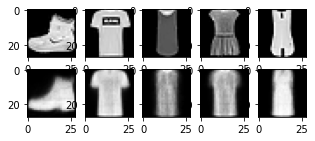

[Epoch 2]


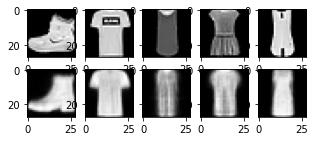

[Epoch 3]


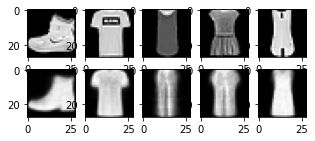

[Epoch 4]


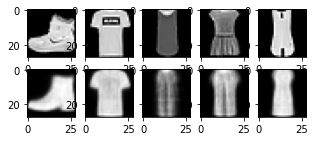

[Epoch 5]


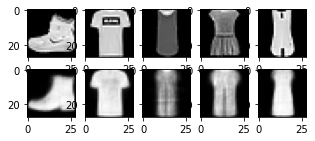

[Epoch 6]


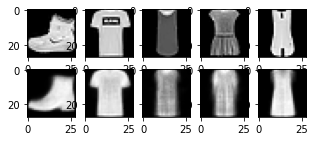

[Epoch 7]


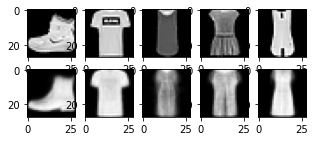

[Epoch 8]


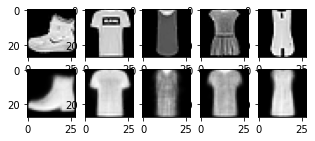

[Epoch 9]


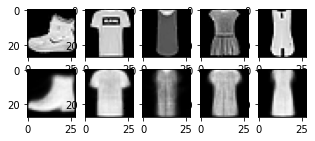

[Epoch 10]


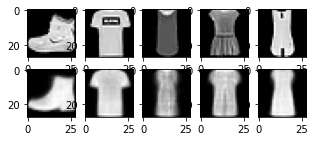

In [13]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print(f"[Epoch {epoch}]")
    
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28, 28))
        a[0][i].imshow(img, cmap='gray')
    
    for i in range(5):
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')

    plt.show()

잠재 변수 들여다보기

In [14]:
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

In [15]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [16]:
view_data.data.size()
encoded_data[0]

tensor([-5.0708, -2.9309,  4.3942], grad_fn=<SelectBackward0>)

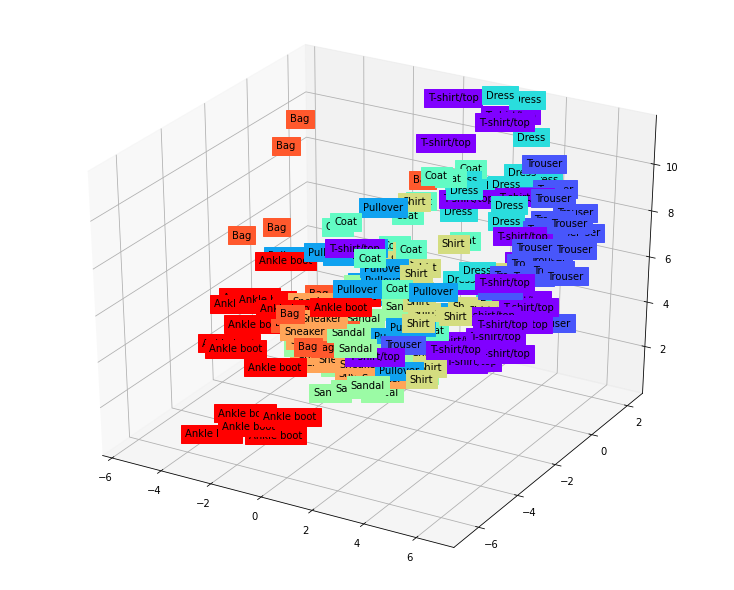

In [17]:
# 인코딩한 3차원 벡터로 데이터 시각화 하기
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z, name, backgroundcolor=color)

    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_zlim(Z.min(), Z.max())
    
plt.show()

### 오토인코더로 망가진 이미지 복원하기

In [26]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [27]:
def add_noise(img):     # 이미지에 잡음 추가해주는 함수
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [28]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [29]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print(f"[Epoch {epoch}] loss: {loss}")

[Epoch 1] loss: 0.03398414532632144
[Epoch 2] loss: 0.025598066134143994
[Epoch 3] loss: 0.02447228329673187
[Epoch 4] loss: 0.0236924296177463
[Epoch 5] loss: 0.02341075722318786
[Epoch 6] loss: 0.023048972137081725
[Epoch 7] loss: 0.022862153505084356
[Epoch 8] loss: 0.022598612189753606
[Epoch 9] loss: 0.0225015913507641
[Epoch 10] loss: 0.022274122490033285


In [39]:
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [59]:
sample_data = testset.test_data[:2].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [60]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

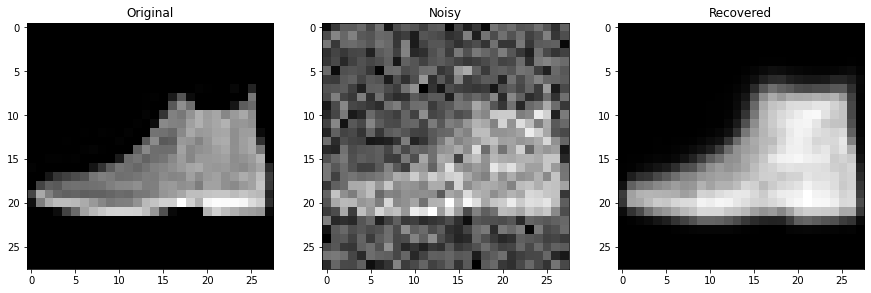

In [61]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

# 원본 이미지
a[0].set_title("Original")
a[0].imshow(original_img, cmap='gray')

# 오염된 이미지
a[1].set_title("Noisy")
a[1].imshow(noisy_img, cmap='gray')

# 복원된 이미지
a[2].set_title("Recovered")
a[2].imshow(recovered_img, cmap='gray')

plt.show()

In [62]:
original_x = sample_data[1]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

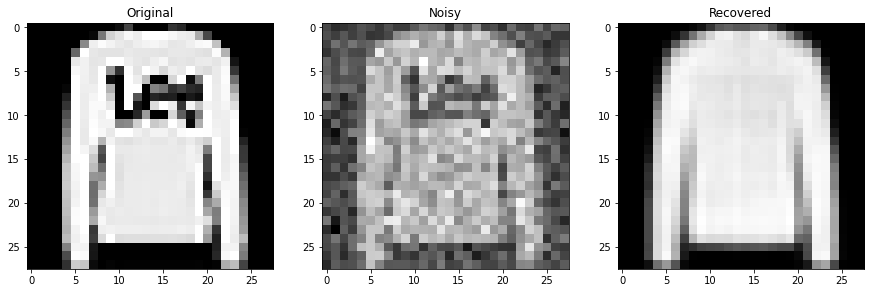

In [63]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

a[0].set_title("Original")
a[0].imshow(original_img, cmap='gray')

a[1].set_title("Noisy")
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title("Recovered")
a[2].imshow(recovered_img, cmap='gray')

plt.show()